In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
import os 

# For Data PreProcessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.utils import to_categorical
from random import randint, choice

# Old DBN Class
# from dbn.tensorflow import SupervisedDBNClassification

# Models used
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF 
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import BernoulliRBM
from sklearn.model_selection import GridSearchCV

from dbn import SupervisedDBNClassification

In [2]:
# Get Data from File
csv_filename = "qc aggregated data.csv"
df = pd.read_csv(csv_filename)

# Specify Input and Output from Data
# input_columns = ["tempmax", "tempmin", "temp", "feelslikemax", "feelslikemin", "feelslike", "dew", "humidity", "windspeed"]
input_columns = ["temp", "feelslike", "dew", "humidity", "windspeed"]
output_column = ["conditions"]

df = df[input_columns + output_column]
df.conditions = df.conditions.shift(-1)
df.dropna(inplace=True)

In [3]:
X = df[input_columns].to_numpy()
Y = df[output_column].to_numpy()
X = X.astype(float)
X = X - X.min()
X = X / X.max()

le = LabelEncoder()
Y = le.fit_transform(Y)

c:\Users\Alaric\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [5]:
win_length = 5
new_X = []
new_Y = []
for row in range(win_length, len(X)):
    t_l = list(X[row])
    for prev_row in range(row-1, row-win_length-1, -1):
        t_l.extend(list(X[prev_row]))
    new_X.append(t_l)

    new_Y.append(Y[row])

new_X = np.array(new_X)
new_Y = np.array(new_Y)
X = new_X 
Y = new_Y

In [6]:
X[0], Y[0]

(array([0.17201166, 0.19023324, 0.12463557, 0.46574344, 0.1122449 ,
        0.16836735, 0.18731778, 0.13702624, 0.53862974, 0.12390671,
        0.16180758, 0.17492711, 0.12973761, 0.53134111, 0.1377551 ,
        0.15816327, 0.16472303, 0.11588921, 0.48177843, 0.13848397,
        0.1574344 , 0.1654519 , 0.11588921, 0.48542274, 0.1516035 ,
        0.15524781, 0.16399417, 0.11443149, 0.48906706, 0.12536443]),
 3)

In [7]:
Y[1]

3

In [8]:
conditions, counts = np.unique(Y, return_counts=True)
target_num = max(counts)

new_X = []
new_Y = []

for condition in conditions:
    #print(condition)
    available_roster = np.where(Y == condition)
    available_roster = available_roster[0]

    t_l_x = []
    t_l_y = []


    for roster in available_roster:
        t_l_x.append(X[roster].tolist())
        t_l_y.append(Y[roster])
    
    #print(np.array(t_l_x))
    #break 

    target_clocks = target_num - len(t_l_x)

    for rem in range(target_clocks):
        r_i = choice(available_roster)
        #print("Choice: " ,r_i, " Roster: ", available_roster)
        t_l_x.append(X[r_i].tolist())
        t_l_y.append(Y[r_i])
    
    print(np.array(t_l_x).shape, target_num)

    new_X.extend(t_l_x)
    new_Y.extend(t_l_y)

new_X = np.array(new_X)
new_Y = np.array(new_Y)
X = new_X
Y = new_Y
    



(1213, 30) 1213
(1213, 30) 1213
(1213, 30) 1213
(1213, 30) 1213


In [9]:
new_X.shape, target_num * 4, new_Y.shape, new_Y[4852-1214]

((4852, 30), 4852, (4852,), 2)

In [10]:
X[0], Y[0]

(array([0.17201166, 0.22303207, 0.15962099, 0.62682216, 0.24125364,
        0.17346939, 0.2244898 , 0.15816327, 0.61078717, 0.21793003,
        0.17274052, 0.21501458, 0.15306122, 0.59110787, 0.23177843,
        0.17274052, 0.21793003, 0.15451895, 0.59985423, 0.23833819,
        0.16690962, 0.19897959, 0.15451895, 0.62755102, 0.2048105 ,
        0.16326531, 0.19241983, 0.15233236, 0.6319242 , 0.22813411]),
 0)

In [11]:
# Preprocess the data (Convert raw string conditions to numerical values, and split data)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
while (len(np.unique(Y_train)) != len(le.classes_)) or (len(np.unique(Y_test)) != len(le.classes_)):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Class mapping - used later for labelling
label_mapping = {x: y for x, y in zip(le.transform(le.classes_), le.classes_)}
lm = list(label_mapping.values())
lm = [x.replace(",", ",\n") for x in lm]

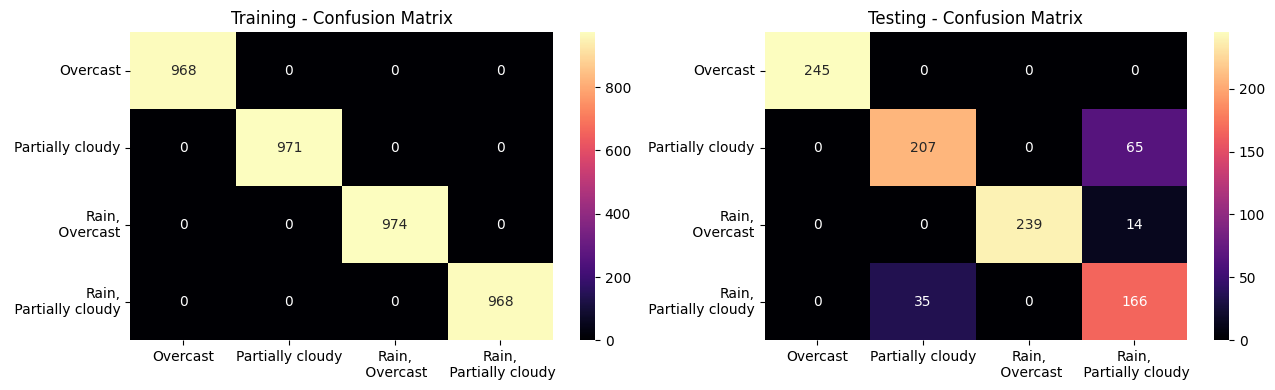

Testing: 0.88259526261586 
Training: 1.0


In [12]:
learning_rate = 0.001
total_units = 64
total_epochs = 10
batch_size = 32

# RBM
rbm = BernoulliRBM(n_components=total_units, learning_rate=learning_rate, batch_size=batch_size, n_iter=total_epochs, verbose=0)

# Random Forest
r_forest = RandomForestClassifier(verbose=0)

# Decision Tree
d_tree = DecisionTreeClassifier()

# SVC
s_v_c = SVC()

# Gaussian
gpc = GaussianProcessClassifier()

# K Neighbors
kneighhclassif = KNeighborsClassifier()


# ('rbm1', clone(rbm)),
model = Pipeline(steps=[
    ('rbm1', clone(rbm)), 
    ('rbm2', clone(rbm)),
    ('rfc', clone(r_forest))
    #("dtree1", clone(d_tree))
    #("support", clone(s_v_c))
    #("knn", clone(kneighhclassif))
    #("gauss", GaussianProcessClassifier())
    ])
model.fit(X_train, Y_train)

# Predict on training (for verification)
Y_pred_train = model.predict(X_train)
CM_train = confusion_matrix(Y_pred_train, Y_train)
train_acc = accuracy_score(Y_train, Y_pred_train)

# Testing Plot
plt.figure(figsize=(15, 4))
ax = plt.subplot(121)
ax.set_title("Training - Confusion Matrix")
sns.heatmap(CM_train, annot=True, cmap="magma", ax=ax, fmt='d')
ax.xaxis.set_ticklabels(lm)
ax.yaxis.set_ticklabels(lm)
plt.yticks(rotation=0)

# Predict on testing (for verification)
Y_pred_test = model.predict(X_test)
CM_test = confusion_matrix(Y_pred_test, Y_test)
test_acc = accuracy_score(Y_test, Y_pred_test)

ax2 = plt.subplot(122)
ax2.set_title("Testing - Confusion Matrix")
sns.heatmap(CM_test, annot=True, cmap="magma", ax=ax2, fmt='d')
ax2.xaxis.set_ticklabels(lm)
ax2.yaxis.set_ticklabels(lm)
plt.yticks(rotation=0)

plt.show()
print(f"Testing: {test_acc} \nTraining: {train_acc}")

In [15]:
classifier = SupervisedDBNClassification(hidden_layers_structure=[64, 64],
                                         learning_rate_rbm=0.001,
                                         learning_rate=0.1,
                                         n_epochs_rbm=10,
                                         n_iter_backprop=10,
                                         batch_size=32,
                                         activation_function='relu',
                                         dropout_p=0)


classifier.fit(X_train, Y_train)

[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 1.525711
>> Epoch 2 finished 	RBM Reconstruction error 1.115789
>> Epoch 3 finished 	RBM Reconstruction error 0.761910
>> Epoch 4 finished 	RBM Reconstruction error 0.468211
>> Epoch 5 finished 	RBM Reconstruction error 0.254422
>> Epoch 6 finished 	RBM Reconstruction error 0.130981
>> Epoch 7 finished 	RBM Reconstruction error 0.075392
>> Epoch 8 finished 	RBM Reconstruction error 0.053532
>> Epoch 9 finished 	RBM Reconstruction error 0.046857
>> Epoch 10 finished 	RBM Reconstruction error 0.044708
>> Epoch 1 finished 	RBM Reconstruction error 0.933335
>> Epoch 2 finished 	RBM Reconstruction error 0.703844
>> Epoch 3 finished 	RBM Reconstruction error 0.518431
>> Epoch 4 finished 	RBM Reconstruction error 0.370039
>> Epoch 5 finished 	RBM Reconstruction error 0.253706
>> Epoch 6 finished 	RBM Reconstruction error 0.166513
>> Epoch 7 finished 	RBM Reconstruction error 0.104050
>> Epoch 8 finished 	RBM Reconstructi

SupervisedDBNClassification()

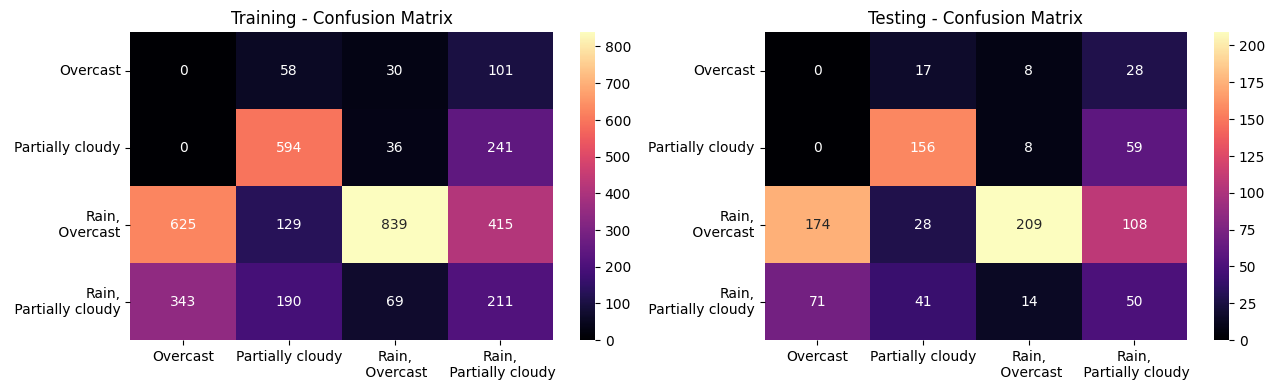

Testing: 0.427394438722966 
Training: 0.423602164390621


In [16]:
# Predict on training (for verification)
Y_pred_train = classifier.predict(X_train)
CM_train = confusion_matrix(Y_pred_train, Y_train)
train_acc = accuracy_score(Y_train, Y_pred_train)

# Testing Plot
plt.figure(figsize=(15, 4))
ax = plt.subplot(121)
ax.set_title("Training - Confusion Matrix")
sns.heatmap(CM_train, annot=True, cmap="magma", ax=ax, fmt='d')
ax.xaxis.set_ticklabels(lm)
ax.yaxis.set_ticklabels(lm)
plt.yticks(rotation=0)

# Predict on testing (for verification)
Y_pred_test = classifier.predict(X_test)
CM_test = confusion_matrix(Y_pred_test, Y_test)
test_acc = accuracy_score(Y_test, Y_pred_test)

ax2 = plt.subplot(122)
ax2.set_title("Testing - Confusion Matrix")
sns.heatmap(CM_test, annot=True, cmap="magma", ax=ax2, fmt='d')
ax2.xaxis.set_ticklabels(lm)
ax2.yaxis.set_ticklabels(lm)
plt.yticks(rotation=0)

plt.show()
print(f"Testing: {test_acc} \nTraining: {train_acc}")